# EDA & Model Investigation
### Forecasting Using Holt-Winter Model
An exponential smoothing model

In this notebook only one dataset will be used to review the change in CPI from 2017 up until April 2023. 

The logic used in this article will be used to get up to speed with Bayesian methods for forecasting:
https://towardsdatascience.com/time-series-forecasting-with-holt-winters-b78ffc322f24

The Holt-Winters model is an exponential smoothing time-series model that makes provision for trend and seasonality in a time series.

### Step 1: Import Libraries

Import the following libraries:
- pandas:
    - provides tools for working with structured data.
- numpy:
    - provides powerful numerical computing tools. 
- matplotlib:
    - allows us to create visualizations of our data
- datetime:
    - provides functions for working with dates and times. 
- pymc3:
    - provides the funcionality to fit a MCMC model.
- Import specific functions from the scikit-learn library, including:
    - train_test_split for splitting our data into training and testing sets.
    - mean_squared_error for evaluating the performance of our model.
    - LinearRegression for fitting a linear regression model.
    - StandardScaler for standardizing our data.

In [468]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader
import pandas_datareader as pdr

from statsmodels.tsa.forecasting.theta import ThetaModel

plt.style.use("seaborn")
register_matplotlib_converters()

# Import packages
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import nbformat
import plotly.io as pio
pio.renderers.default='notebook'

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Step 2: Import the dataset

I will import three data sets:
- `EXCEL - CPI(5 and 8 digit) from Jan 2017 (202304).xlsx`: this will be used to do the EDA and initial prediction of the CPI values.
- `CPI_Historic_Values_Zindi_Mar_23.csv`: this data was provided on the Zindi website and will be used to confirm that the calculations on the raw data is correct.
- `Zindi_CPI_Predictions_April.xlsx`: this data is the example predictions for the April 2023 data on Zindi and will be used to compare the predictions from the simple model.

In [2]:
raw_df = pd.read_excel("EXCEL - CPI(5 and 8 digit) from Jan 2017 (202304).xlsx", dtype="object")
historic_zindi_cpi_df= pd.read_csv("CPI_Historic_Values_Zindi_Mar_23.csv")
pred_zindi_april_df = pd.read_excel("Zindi_CPI_Predictions_April.xlsx")

### Step 3: Review the Historical CPI data and Create a Summary DataFrame

In [3]:
raw_df.shape

(225, 84)

There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories. This data set contains the CPI on sub-category level.

Create a dataset where the CPI is calculated on the category level. These values will then be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. 
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month using the weights provided in the file.

#### 1. Drop unnecessary columns & rename columns

In [4]:
list_cols_to_drop = ['H01','H02','H05','H06','H07']
cat_cpi_df = raw_df.drop(list_cols_to_drop, axis=1).copy()

In [5]:
cat_cpi_df.rename(columns = {'H03':'category_codes', 'H04':'category_descr', 
                             'Weight (All urban)':'weights_urban'}, inplace = True)

#### 2. Replace all `..` entries with a `0`.

In [6]:
print(cat_cpi_df.dtypes.unique())

[dtype('O')]


In [7]:
# find all '..' entries in the dataframe
cat_cpi_df[cat_cpi_df.eq('..').any(axis=1)]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
15,01116003,Maize meal,0.76,..,..,..,..,..,..,..,...,121.9,127.8,126.2,128.4,131.2,133.7,137.9,141,142.3,142.4
17,01116008,Super maize,..,118.4,119,116.4,112.9,108,104.2,101,...,..,..,..,..,..,..,..,..,..,..
18,01116009,Special maize,..,126,126.2,121.1,116.5,118.8,116.8,104.5,...,..,..,..,..,..,..,..,..,..,..
21,01116012,Samp,0.01,..,..,..,..,..,..,..,...,116.5,119,120.8,120.6,122.9,125.9,130.4,132.7,135.9,134.1
97,01182001,Jam,0.02,..,..,..,..,..,..,..,...,105,107.7,110.8,110.4,110.9,109.6,110.7,110.8,113,112.4
116,01193008,Baby food - pureed bottled/pouched,0.05,..,..,..,..,..,..,..,...,107.7,110.5,111.3,112.8,112.8,112.7,112.9,113.1,113.4,116.5
119,01211003,Cappucino sachets,0.03,..,..,..,..,..,..,..,...,109.8,110.4,111,112.8,113.2,112.3,114.1,115.3,115.8,117.2
129,01223003,Dairy blends/mixtures,0.07,..,..,..,..,..,..,..,...,108.7,110.2,114.9,119.5,121.4,120.4,120.2,122.7,119.9,120.2
137,02122002,Gin,0.10,..,..,..,..,..,..,..,...,106.8,106,107.1,107.8,108,107.3,108.2,107.8,108.9,110.5


There are products which were included in the CPI calculations at a later stage and some products that were removed from the CPI calculation. Categories with no value at the time has a `..`, I will replace them with a `0`. The type of the column can then be updated to float.

In [8]:
cat_cpi_df.replace("..", 0, inplace=True)

In [9]:
cat_cpi_df[cat_cpi_df.eq(0).any(axis=1)]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
15,01116003,Maize meal,0.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.9,127.8,126.2,128.4,131.2,133.7,137.9,141.0,142.3,142.4
17,01116008,Super maize,0,118.4,119.0,116.4,112.9,108.0,104.2,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,01116009,Special maize,0,126.0,126.2,121.1,116.5,118.8,116.8,104.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,01116012,Samp,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,116.5,119.0,120.8,120.6,122.9,125.9,130.4,132.7,135.9,134.1
97,01182001,Jam,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105.0,107.7,110.8,110.4,110.9,109.6,110.7,110.8,113.0,112.4
116,01193008,Baby food - pureed bottled/pouched,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,107.7,110.5,111.3,112.8,112.8,112.7,112.9,113.1,113.4,116.5
119,01211003,Cappucino sachets,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,109.8,110.4,111.0,112.8,113.2,112.3,114.1,115.3,115.8,117.2
129,01223003,Dairy blends/mixtures,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,108.7,110.2,114.9,119.5,121.4,120.4,120.2,122.7,119.9,120.2
137,02122002,Gin,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,106.8,106.0,107.1,107.8,108.0,107.3,108.2,107.8,108.9,110.5


#### 3. Combine the `Maize` categories

In [10]:
cat_cpi_df.shape

(225, 79)

In [11]:
# Convert the Super maize and Special maize row to numeric data types.
# The rows will be dropped, so the loss of other information is not a problem.

cat_cpi_df.iloc[17:19] = cat_cpi_df.iloc[17:19].apply(pd.to_numeric, errors='coerce')

# Divide rows A and B
divided_row = (cat_cpi_df.iloc[17]+cat_cpi_df.iloc[18])/2

# Replace the value in row C if it is 0 with the divided value
cat_cpi_df.iloc[15] = [divided_row[i] if value == 0 else value for i, value in enumerate(cat_cpi_df.iloc[15])]

# Remove the rows for Super maize and Special maize
cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)
print(cat_cpi_df.shape)

(223, 79)


In [12]:
# check
cat_cpi_df.iloc[15, 3:].sum()
# 7844.05

7844.050000000002

In [13]:
# check
cat_cpi_df.iloc[17:19]

,category_codes,category_descr,weights_urban,M201701,M201702,M201703,M201704,M201705,M201706,M201707,...,M202207,M202208,M202209,M202210,M202211,M202212,M202301,M202302,M202303,M202304
19,01116010,Hot cereals (porridge) incl instant porridge,0.05,84.4,83.2,83.8,84.1,84.4,84.9,82.1,...,106.0,111.9,112.3,112.4,114.6,115.5,113.1,116.6,118.4,120.6
20,01116011,Ready-mix flour,0.01,83.2,82.7,83.0,82.6,82.8,82.5,82.5,...,113.2,116.4,116.1,116.0,115.1,115.0,115.9,119.0,118.1,119.3


#### NB NB
It may be necessary to fill missing values for the items added to the baskets after the rebase period. Best way might be to replace the 0 values with the first entry for that item.

Review this again, as it depends on which months we include in the modelling.

#### 4. Create a function to calculate the category and headline CPI for each month
Use the logic provided by StatsSA and the weights provided in the data to calculate the CPI for each month.

In [644]:
# Create a category dictionary with the category code and description
category_dict = {"01":"Food and non-alcoholic beverages",
                 "02":"Alcoholic beverages and tobacco",
                 "03":"Clothing and footwear",
                 "04":"Housing and utilities",
                 "05":"Household contents and services",
                 "06":"Health",
                 "07":"Transport",
                 "08":"Communication",
                 "09":"Recreation and culture",
                 "10":"Education",
                 "11":"Restaurants and hotels",
                 "12":"Miscellaneous goods and services",
                 "headline": "headline CPI"
}
# category_dict

In [15]:
# Convert the 'weights_urban' column to float
cat_cpi_df['weights_urban'] = cat_cpi_df['weights_urban'].astype('float')

In [16]:
def create_monthly_cpi(input_df):
    """Create a dataframe with the headline CPI and category CPI values using the raw data as input"""
    
    # Make a copy of the input dataframe
    df = input_df.copy()
    
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row['category_codes']) == 8) & (row['category_codes'][:2] in ["01","02"]):
            main_category.append(row['category_codes'][:2])
        elif (len(row['category_codes']) == 5):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row['category_codes'][:2])
        else:
            main_category.append("no")
    
    df['main_category_code'] = main_category
    
    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    df.drop(df[df['main_category_code'] == "no"].index, inplace = True)
    
    # Sum the weights for each category
    sum_weights = df.groupby('main_category_code')['weights_urban'].sum()
    
    cpi_df = pd.DataFrame()
    
    # For each month create the headline CPI value and the CPI value per category. 
    for col in range(3, df.shape[1]-1):
        column_name = df.columns[col]
        df['weighted_index_' + column_name] = df['weights_urban']*df[column_name]
    
        sum_weighted_index = df.groupby('main_category_code')['weighted_index_' + column_name].sum()
        
        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)
        
        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(concat_df.sum().values.reshape(1, -1), columns=concat_df.columns)
        sums_df = sums_df.set_index(pd.Index(["headline"]))
        
        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0) 
        
        # Calculate the CPI value
        month_cpi_df['cpi_'+column_name] = (month_cpi_df['weighted_index_' + column_name] / 
                                            month_cpi_df['weights_urban']).round(1)
        
        cpi_df = pd.concat([cpi_df, month_cpi_df[['weights_urban', 'cpi_'+column_name]]], axis=1)
    
    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={'index':'category'})
    
    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop('weights_urban', axis=1).copy()
    
    return(cpi_df)

In [17]:
cpi_summary_df = create_monthly_cpi(cat_cpi_df)

In [18]:
cpi_summary_df

,category,cpi_M201701,cpi_M201702,cpi_M201703,cpi_M201704,cpi_M201705,cpi_M201706,cpi_M201707,cpi_M201708,cpi_M201709,...,cpi_M202207,cpi_M202208,cpi_M202209,cpi_M202210,cpi_M202211,cpi_M202212,cpi_M202301,cpi_M202302,cpi_M202303,cpi_M202304
0,01,81.6,82.2,82.4,82.3,82.7,82.6,82.6,82.3,82.3,...,107.8,109.7,110.3,111.3,112.0,112.4,114.4,115.5,116.7,117.4
1,02,78.5,78.3,79.5,80.1,80.3,80.4,80.6,81.7,82.0,...,104.3,104.7,105.6,106.1,106.4,106.2,106.5,106.9,109.2,110.2
2,03,92.7,93.0,93.3,93.3,93.5,93.5,93.5,93.6,93.7,...,101.6,102.1,102.4,102.7,102.6,102.8,102.9,103.5,103.4,103.7
3,04,82.1,82.1,82.8,82.8,82.8,83.6,84.5,84.5,85.3,...,103.1,103.2,103.8,103.8,103.8,104.1,104.1,104.2,104.5,104.6
4,05,90.5,90.2,90.7,90.5,90.6,91.2,91.1,90.9,91.3,...,103.3,103.6,104.5,105.0,105.2,106.1,106.6,106.6,107.8,107.7
5,06,79.3,82.3,83.0,83.4,83.6,83.8,84.0,83.8,84.0,...,104.1,104.2,104.0,104.5,104.7,104.7,104.9,108.5,109.1,109.5
6,07,76.7,77.3,77.2,77.0,77.8,77.5,76.6,76.9,78.1,...,115.6,114.5,112.0,111.7,113.1,113.9,109.9,110.6,112.9,113.1
7,08,103.7,103.6,102.9,102.9,102.7,102.4,102.3,102.1,101.9,...,99.9,100.1,99.9,99.8,99.2,99.1,99.4,99.8,99.7,99.8
8,09,96.9,97.1,97.2,97.3,97.3,97.4,97.5,97.5,97.3,...,102.4,102.4,102.5,102.7,102.9,103.5,103.5,103.3,104.3,105.0
9,10,74.2,74.2,79.4,79.4,79.4,79.4,79.4,79.4,79.4,...,104.4,104.4,104.4,104.4,104.4,104.4,104.4,104.4,110.4,110.4


In [19]:
# Transpose the dataframe so that each category is a separate column.
transposed_cpi_df = cpi_summary_df.set_index('category').transpose()
transposed_cpi_df.tail()

category,01,02,03,04,05,06,07,08,09,10,11,12,headline
cpi_M202212,112.4,106.2,102.8,104.1,106.1,104.7,113.9,99.1,103.5,104.4,107.8,104.9,107.2
cpi_M202301,114.4,106.5,102.9,104.1,106.6,104.9,109.9,99.4,103.5,104.4,106.8,105.4,107.1
cpi_M202302,115.5,106.9,103.5,104.2,106.6,108.5,110.6,99.8,103.3,104.4,108.8,107.7,107.9
cpi_M202303,116.7,109.2,103.4,104.5,107.8,109.1,112.9,99.7,104.3,110.4,109.6,107.8,109.0
cpi_M202304,117.4,110.2,103.7,104.6,107.7,109.5,113.1,99.8,105.0,110.4,108.6,109.3,109.4


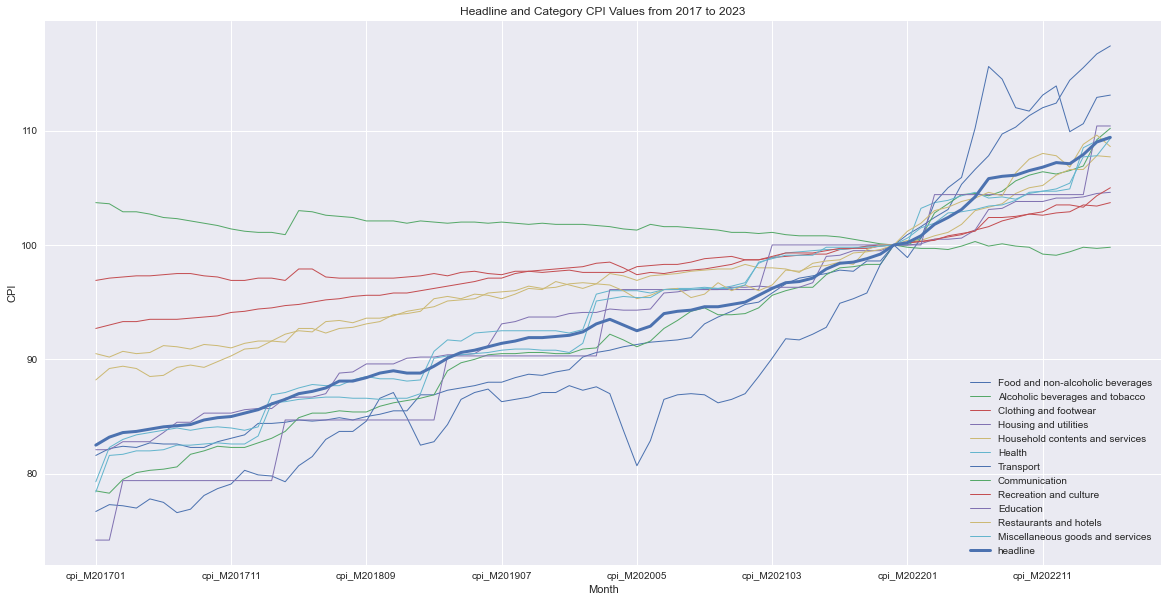

In [20]:
# Plot the data
ax = transposed_cpi_df.plot.line(linewidth=1, figsize=(20,10))  # Set the default linewidth

# Increasing thickness of a specific line.
ax.lines[12].set_linewidth(3)

# Modify the legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [category_dict.get(label, label) for label in labels]
plt.legend(handles, new_labels)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('CPI')
plt.title('Headline and Category CPI Values from 2017 to 2023')

# Displaying the graph
plt.show()

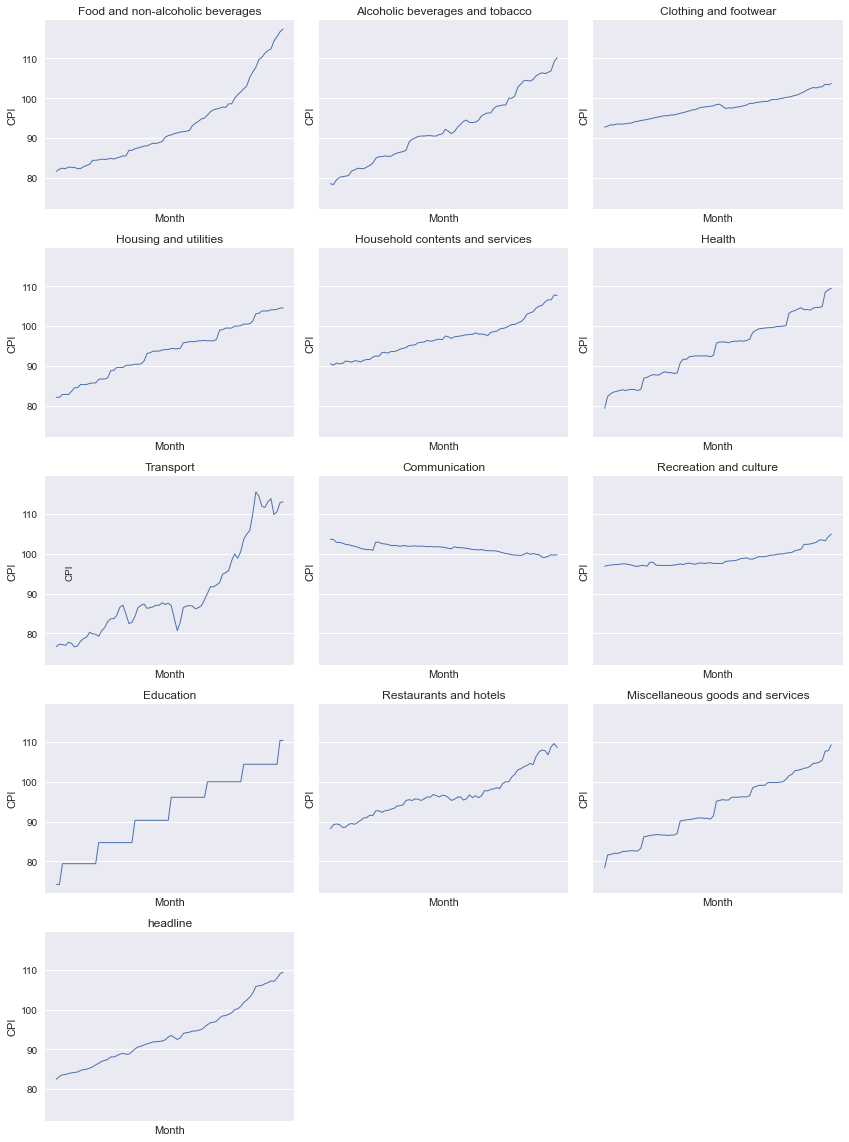

In [21]:
# Plot each category separately to see which categories show the most change over time.
# Determine the number of rows and columns for the grid
n_rows = 5
n_cols = 3

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 16), sharey=True)

# Iterate over each series and plot on the subplots
for i, column in enumerate(transposed_cpi_df.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.plot(transposed_cpi_df.index, transposed_cpi_df[column], linewidth=1)
    ax.set_title(category_dict.get(column, column))
    ax.set_xlabel('Month')
    ax.set_ylabel('CPI')
    ax.set_xticks([]) 

# Remove unused subplots
for i in range(n_rows * n_cols, len(transposed_cpi_df.columns)):
    fig.delaxes(axes.flatten()[i])

# Set common y-axis label
fig.text(0.08, 0.5, 'CPI', va='center', rotation='vertical')


# Adjust spacing between subplots and remove unused subplots
plt.tight_layout()
fig.delaxes(axes[4, 1])
fig.delaxes(axes[4, 2])


#### Change the format of the date to be in date format

In [22]:
monthly_cpi_df = transposed_cpi_df.copy()

In [23]:
# Reset the index so that the row index becomes a column
monthly_cpi_df.reset_index(inplace=True)

In [24]:
# Rename category column to 'month' and update the entries by removing the first digits and only keeping the date.
monthly_cpi_df.rename(columns = {'index':'year_month'}, inplace = True)
monthly_cpi_df['year_month'] = monthly_cpi_df['year_month'].str[5:]

In [25]:
# Change format of 'year_month' to a datetime format
monthly_cpi_df['year_month'] = pd.to_datetime(monthly_cpi_df['year_month'], format='%Y%m')
# monthly_cpi_df['year_month'] = pd.to_datetime(monthly_cpi_df['year_month'], format='%Y%m').dt.to_period('M')

In [26]:
# make the year-month the index again
# monthly_cpi_df = monthly_cpi_df.set_index('year_month')

In [27]:
monthly_cpi_df.tail()

category,year_month,01,02,03,04,05,06,07,08,09,10,11,12,headline
71,2022-12-01,112.4,106.2,102.8,104.1,106.1,104.7,113.9,99.1,103.5,104.4,107.8,104.9,107.2
72,2023-01-01,114.4,106.5,102.9,104.1,106.6,104.9,109.9,99.4,103.5,104.4,106.8,105.4,107.1
73,2023-02-01,115.5,106.9,103.5,104.2,106.6,108.5,110.6,99.8,103.3,104.4,108.8,107.7,107.9
74,2023-03-01,116.7,109.2,103.4,104.5,107.8,109.1,112.9,99.7,104.3,110.4,109.6,107.8,109.0
75,2023-04-01,117.4,110.2,103.7,104.6,107.7,109.5,113.1,99.8,105.0,110.4,108.6,109.3,109.4


### Step 4: Review each category separately.
- Fit a Holt-Winters model to each category

Create a function that fits a Holt-Winters model to each category.

In [28]:
# Reduce the data set to include the minimum number of data points for a Holt-Winters model to be fitted.

In [ ]:
# Create a dictionary where the predicted CPI for each category will be stored.

In [728]:
# Create a function to predict CPI values for each category using a variety of exponential smoothing models.
def predict_cpi_with_holt_winters(df, len_test_df, nr_months_ahead):
    column_names = df.columns[1:]

    # Iterate through the selected categories
    for column_name in column_names:
        column_data = df[column_name]
        
        cat_df = df[['year_month', column_name]]
        
        # Plot the series
#         fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
#         ax.plot(cat_df['year_month'], cat_df[column_name], label=r"CPI", lw=2)
#         ax.legend(loc="lower right")
#         plt.show()
        
        # Set the random seed
        np.random.seed(111)
        
        # Define the Holt-Winters model.

        # Split train and test
        # Currently only use the last two values as test values
#         train = df.iloc[:-int(len(df) * 0.05)]
#         test = df.iloc[-int(len(df) * 0.05):] 
        train = cat_df.iloc[:-len_test_df]
        test = cat_df.iloc[-len_test_df:]
        
        # Function to plot the time series with the different predictions on the test data.
        def plot_func(forecast1: list[float],
                      forecast2: list[float],
                      forecast3: list[float],
                      title: str,
                     ):
            """Function to plot the forecasts."""
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=train['year_month'], y=train[column_name], name='Train'))
            fig.add_trace(go.Scatter(x=test['year_month'], y=test[column_name], name='Test'))
            fig.add_trace(go.Scatter(x=test['year_month'], y=forecast1, name='Simple'))
            fig.add_trace(go.Scatter(x=test['year_month'], y=forecast2, name="Holt's Linear"))
            fig.add_trace(go.Scatter(x=test['year_month'], y=forecast3, name='Holt Winters'))
            fig.update_layout(# template="simple_white", 
                              font=dict(size=14), title_text=title,
                              width=900, title_x=0.5, height=500, xaxis_title='Date',
                              yaxis_title='CPI')
            return fig.show()


        # Fit simple model and get forecasts
        model_simple = SimpleExpSmoothing(train[column_name]).fit(optimized=True)
        forecasts_simple = model_simple.forecast(len(test))

        # Fit Holt's model and get forecasts
        model_holt = Holt(train[column_name], damped_trend=True).fit(optimized=True)
        forecasts_holt = model_holt.forecast(len(test))

        # Fit Holt Winters model and get forecasts
        model_holt_winters = ExponentialSmoothing(train[column_name], trend='mul',
                                                  seasonal='mul', seasonal_periods=12)\
                                                  .fit(optimized=True)
        forecasts_holt_winters = model_holt_winters.forecast(len(test))

        # Plot the forecasts
        plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  
                  f"Holt-Winters Exponential Smoothing: {category_dict[column_name]}")
        
        # Create the date for new forecasted value
        pred_date = cat_df['year_month'].iloc[-1:] + pd.DateOffset(months=nr_months_ahead)
        pred_year_month = np.datetime_as_string(pred_date, unit='D')[0]
        
        # Forecast new value(s) using the full data set to train
        model_holt_winters = ExponentialSmoothing(cat_df[column_name], trend='mul',
                                                  seasonal='mul', seasonal_periods=12)\
                                                  .fit(optimized=True)
        pred_cpi_holt_winters = model_holt_winters.forecast(2).values[nr_months_ahead-1]
        print(pred_cpi_holt_winters)
        
        # Add prediction to CPI dictionary
        cpi_dict[column_name] = [pred_year_month, pred_cpi_holt_winters]
        
        print(f"New predicted value: {cpi_dict[column_name]}")
        print("\n")
        print(f"Predictions on test data:")
        print(forecasts_holt_winters)
        print("\n")
        print(f"Test Data:")
        print(test)
#         return(forecasts_holt_winters)

### Category 1: Food and non-alcoholic beverages

In [729]:
cat1_cpi = monthly_cpi_df.iloc[:,0:2]
# cat1_cpi.head()

In [730]:
reduced_cat1_cpi = cat1_cpi.drop(index=cat1_cpi.index[:36]).copy()

In [732]:
cat1_predict = predict_cpi_with_holt_winters(reduced_cat1_cpi, len_test_df=3, nr_months_ahead=2)

119.94690281522752
New predicted value: ['2023-06-01', 119.94690281522752]


Predictions on test data:
73    115.406190
74    116.603494
75    117.782375
dtype: float64


Test Data:
category year_month     01
73       2023-02-01  115.5
74       2023-03-01  116.7
75       2023-04-01  117.4


In [733]:
pred_zindi_april_df[2:3]

,ID,Value
2,April_Food and non-alcoholic beverages,117.94


### Category 2: Alcoholic beverages and tobacco

In [498]:
cat2_cpi = monthly_cpi_df[['year_month', '02']]
cat2_cpi.head()

category,year_month,02
0,2017-01-01,78.5
1,2017-02-01,78.3
2,2017-03-01,79.5
3,2017-04-01,80.1
4,2017-05-01,80.3


In [499]:
reduced_cat2_cpi = cat2_cpi.drop(index=cat2_cpi.index[:48]).copy()

In [734]:
cat2_predict = predict_cpi_with_holt_winters(reduced_cat2_cpi, len_test_df=3, nr_months_ahead=2)

110.86190864822233
New predicted value: ['2023-06-01', 110.86190864822233]


Predictions on test data:
73    107.097546
74    108.925900
75    109.591699
dtype: float64


Test Data:
category year_month     02
73       2023-02-01  106.9
74       2023-03-01  109.2
75       2023-04-01  110.2


In [501]:
pred_zindi_april_df[12:13]

,ID,Value
12,April_Alcoholic beverages and tobacco,107.11


### Category 3: Clothing and footwear

In [502]:
cat3_cpi = monthly_cpi_df[['year_month', '03']]
cat3_cpi.head(3)

category,year_month,03
0,2017-01-01,92.7
1,2017-02-01,93.0
2,2017-03-01,93.3


In [503]:
reduced_cat3_cpi = cat3_cpi.drop(index=cat3_cpi.index[:48]).copy()

In [735]:
cat3_predict = predict_cpi_with_holt_winters(reduced_cat3_cpi, len_test_df=3, nr_months_ahead=2)

104.23554453976782
New predicted value: ['2023-06-01', 104.23554453976782]


Predictions on test data:
73    102.952107
74    103.159036
75    103.314669
dtype: float64


Test Data:
category year_month     03
73       2023-02-01  103.5
74       2023-03-01  103.4
75       2023-04-01  103.7


In [505]:
pred_zindi_april_df[11:12]

,ID,Value
11,April_Clothing and footwear,103.29


### Category 4: Housing and utilities

In [506]:
cat4_cpi = monthly_cpi_df[['year_month', '04']]
cat4_cpi.head(3)

category,year_month,04
0,2017-01-01,82.1
1,2017-02-01,82.1
2,2017-03-01,82.8


In [508]:
reduced_cat4_cpi = cat4_cpi.drop(index=cat4_cpi.index[:48]).copy()

In [736]:
cat4_predict = predict_cpi_with_holt_winters(reduced_cat4_cpi, len_test_df=3, nr_months_ahead=2)

105.21262683786807
New predicted value: ['2023-06-01', 105.21262683786807]


Predictions on test data:
73    104.219863
74    104.383868
75    104.384001
dtype: float64


Test Data:
category year_month     04
73       2023-02-01  104.2
74       2023-03-01  104.5
75       2023-04-01  104.6


In [510]:
pred_zindi_april_df[10:11]

,ID,Value
10,April_Housing and utilities,104.45


### Category 5: Household contents and services

In [511]:
cat5_cpi = monthly_cpi_df[['year_month', '05']]
cat5_cpi.head(3)

category,year_month,05
0,2017-01-01,90.5
1,2017-02-01,90.2
2,2017-03-01,90.7


In [512]:
reduced_cat5_cpi = cat5_cpi.drop(index=cat5_cpi.index[:48]).copy()

In [737]:
cat5_predict = predict_cpi_with_holt_winters(reduced_cat5_cpi, len_test_df=3, nr_months_ahead=2)

109.77599451625714
New predicted value: ['2023-06-01', 109.77599451625714]


Predictions on test data:
73    106.736498
74    107.230811
75    107.598227
dtype: float64


Test Data:
category year_month     05
73       2023-02-01  106.6
74       2023-03-01  107.8
75       2023-04-01  107.7


In [514]:
pred_zindi_april_df[9:10]

,ID,Value
9,April_Household contents and services,108.31


### Category 6: Health

In [598]:
cat6_cpi = monthly_cpi_df[['year_month', '06']]
cat6_cpi.head(3)

category,year_month,06
0,2017-01-01,79.3
1,2017-02-01,82.3
2,2017-03-01,83.0


In [599]:
reduced_cat6_cpi = cat6_cpi.drop(index=cat6_cpi.index[:24]).copy()

In [738]:
cat6_predict = predict_cpi_with_holt_winters(reduced_cat6_cpi, len_test_df=3, nr_months_ahead=2)

109.86904311728428
New predicted value: ['2023-06-01', 109.86904311728428]


Predictions on test data:
73    107.790850
74    108.420870
75    108.566409
dtype: float64


Test Data:
category year_month     06
73       2023-02-01  108.5
74       2023-03-01  109.1
75       2023-04-01  109.5


In [601]:
pred_zindi_april_df[8:9]

,ID,Value
8,April_Health,105.28


### Category 7: Transport

In [602]:
cat7_cpi = monthly_cpi_df[['year_month', '07']]
cat7_cpi.head(3)

category,year_month,07
0,2017-01-01,76.7
1,2017-02-01,77.3
2,2017-03-01,77.2


In [603]:
reduced_cat7_cpi = cat7_cpi.drop(index=cat7_cpi.index[:36]).copy()

In [739]:
cat7_predict = predict_cpi_with_holt_winters(reduced_cat7_cpi, len_test_df=3, nr_months_ahead=2)

115.2726738070581
New predicted value: ['2023-06-01', 115.2726738070581]


Predictions on test data:
73    111.329483
74    113.071084
75    113.112061
dtype: float64


Test Data:
category year_month     07
73       2023-02-01  110.6
74       2023-03-01  112.9
75       2023-04-01  113.1


In [605]:
pred_zindi_april_df[1:2]

,ID,Value
1,April_Transport,105.53


### Category 8: Communication

In [606]:
cat8_cpi = monthly_cpi_df[['year_month', '08']]
cat8_cpi.head(3)

category,year_month,08
0,2017-01-01,103.7
1,2017-02-01,103.6
2,2017-03-01,102.9


In [607]:
reduced_cat8_cpi = cat8_cpi.drop(index=cat8_cpi.index[:48]).copy()

In [740]:
cat8_predict = predict_cpi_with_holt_winters(reduced_cat8_cpi, len_test_df=3, nr_months_ahead=2)

100.08977152819621
New predicted value: ['2023-06-01', 100.08977152819621]


Predictions on test data:
73    99.300976
74    99.350918
75    99.201992
dtype: float64


Test Data:
category year_month    08
73       2023-02-01  99.8
74       2023-03-01  99.7
75       2023-04-01  99.8


In [609]:
pred_zindi_april_df[6:7]

,ID,Value
6,April_Communication,99.52


### Category 9: Recreation and culture

In [610]:
cat9_cpi = monthly_cpi_df[['year_month', '09']]
cat9_cpi.head(3)

category,year_month,09
0,2017-01-01,96.9
1,2017-02-01,97.1
2,2017-03-01,97.2


In [611]:
reduced_cat9_cpi = cat9_cpi.drop(index=cat9_cpi.index[:24]).copy()

In [741]:
cat9_predict = predict_cpi_with_holt_winters(reduced_cat9_cpi, len_test_df=3, nr_months_ahead=2)

105.46834248538931
New predicted value: ['2023-06-01', 105.46834248538931]


Predictions on test data:
73    103.747787
74    103.998622
75    104.465704
dtype: float64


Test Data:
category year_month     09
73       2023-02-01  103.3
74       2023-03-01  104.3
75       2023-04-01  105.0


In [613]:
pred_zindi_april_df[7:8]

,ID,Value
7,April_Recreation and culture,103.97


### Category 10: Education

In [614]:
cat10_cpi = monthly_cpi_df[['year_month', '10']]
cat10_cpi.head(3)

category,year_month,10
0,2017-01-01,74.2
1,2017-02-01,74.2
2,2017-03-01,79.4


In [615]:
reduced_cat10_cpi = cat10_cpi.drop(index=cat10_cpi.index[:36]).copy()

In [742]:
cat10_predict = predict_cpi_with_holt_winters(reduced_cat10_cpi, len_test_df=3, nr_months_ahead=2)

110.39992192909928
New predicted value: ['2023-06-01', 110.39992192909928]


Predictions on test data:
73    104.399969
74    109.502074
75    109.502093
dtype: float64


Test Data:
category year_month     10
73       2023-02-01  104.4
74       2023-03-01  110.4
75       2023-04-01  110.4


In [617]:
pred_zindi_april_df[5:6]

,ID,Value
5,April_Education,104.41


### Category 11: Restaurants and hotels

In [618]:
cat11_cpi = monthly_cpi_df[['year_month', '11']]
cat11_cpi.head(3)

category,year_month,11
0,2017-01-01,88.2
1,2017-02-01,89.2
2,2017-03-01,89.4


In [619]:
reduced_cat11_cpi = cat11_cpi.drop(index=cat11_cpi.index[:48]).copy()

In [743]:
cat11_predict = predict_cpi_with_holt_winters(reduced_cat11_cpi, len_test_df=3, nr_months_ahead=2)

110.13152558053594
New predicted value: ['2023-06-01', 110.13152558053594]


Predictions on test data:
73    107.076302
74    107.951223
75    108.798837
dtype: float64


Test Data:
category year_month     11
73       2023-02-01  108.8
74       2023-03-01  109.6
75       2023-04-01  108.6


In [621]:
pred_zindi_april_df[4:5]

,ID,Value
4,April_Restaurants and hotels,105.91


### Category 12: Miscellaneous goods and services

In [622]:
cat12_cpi = monthly_cpi_df[['year_month', '12']]
cat12_cpi.head(3)

category,year_month,12
0,2017-01-01,78.4
1,2017-02-01,81.6
2,2017-03-01,81.7


In [629]:
reduced_cat12_cpi = cat12_cpi.drop(index=cat12_cpi.index[:24]).copy()

In [744]:
cat12_predict = predict_cpi_with_holt_winters(reduced_cat12_cpi, len_test_df=3, nr_months_ahead=2)

109.41432980083376
New predicted value: ['2023-06-01', 109.41432980083376]


Predictions on test data:
73    108.057494
74    108.368823
75    108.801991
dtype: float64


Test Data:
category year_month     12
73       2023-02-01  107.7
74       2023-03-01  107.8
75       2023-04-01  109.3


In [631]:
pred_zindi_april_df[3:4]

,ID,Value
3,April_Miscellaneous goods and services,106.55


### Headline CPI

In [635]:
headline_cpi = monthly_cpi_df[['year_month', 'headline']]
headline_cpi.head(3)

category,year_month,headline
0,2017-01-01,82.5
1,2017-02-01,83.2
2,2017-03-01,83.6


In [649]:
reduced_headline_cpi = headline_cpi.drop(index=headline_cpi.index[:48]).copy()

In [745]:
headline_predict = predict_cpi_with_holt_winters(reduced_headline_cpi, len_test_df=3, nr_months_ahead=2)

110.63109165003192
New predicted value: ['2023-06-01', 110.63109165003192]


Predictions on test data:
73    107.757801
74    108.640776
75    109.245333
dtype: float64


Test Data:
category year_month  headline
73       2023-02-01     107.9
74       2023-03-01     109.0
75       2023-04-01     109.4


In [646]:
pred_zindi_april_df[0:1]

,ID,Value
0,April_Headline_CPI,107.44


In [746]:
# Final category predictions
cpi_dict

{'01': ['2023-06-01', 119.94690281522752],
 '02': ['2023-06-01', 110.86190864822233],
 '03': ['2023-06-01', 104.23554453976782],
 '04': ['2023-06-01', 105.21262683786807],
 '05': ['2023-06-01', 109.77599451625714],
 '06': ['2023-06-01', 109.86904311728428],
 '07': ['2023-06-01', 115.2726738070581],
 '08': ['2023-06-01', 100.08977152819621],
 '09': ['2023-06-01', 105.46834248538931],
 '10': ['2023-06-01', 110.39992192909928],
 '11': ['2023-06-01', 110.13152558053594],
 '12': ['2023-06-01', 109.41432980083376],
 'headline': ['2023-06-01', 110.63109165003192]}

In [747]:
prediction_df = pd.DataFrame.from_dict(cpi_dict,orient='index', columns=['Year_Month', 'Value']).reset_index().rename(columns={'index': 'ID'})

In [748]:
prediction_df

,ID,Year_Month,Value
0,01,2023-06-01,119.946903
1,02,2023-06-01,110.861909
2,03,2023-06-01,104.235545
3,04,2023-06-01,105.212627
4,05,2023-06-01,109.775995
5,06,2023-06-01,109.869043
6,07,2023-06-01,115.272674
7,08,2023-06-01,100.089772
8,09,2023-06-01,105.468342
9,10,2023-06-01,110.399922


In [749]:
pred_month = pd.to_datetime(prediction_df['Year_Month'].unique()[0]).strftime('%B')
pred_month

'June'

In [750]:
# drop the month from the dataframe
prediction_df.drop(['Year_Month'], axis=1, inplace=True)

In [751]:
# Create a dictionary to update the category names to allow a submission to Zindi.
# month="May"
pred_category_dict = {"01":pred_month+"_food and non-alcoholic beverages",
                      "02":pred_month+"_alcoholic beverages and tobacco",
                      "03":pred_month+"_clothing and footwear",
                      "04":pred_month+"_housing and utilities",
                      "05":pred_month+"_household contents and services",
                      "06":pred_month+"_health",
                      "07":pred_month+"_transport",
                      "08":pred_month+"_communication",
                      "09":pred_month+"_recreation and culture",
                      "10":pred_month+"_education",
                      "11":pred_month+"_restaurants and hotels",
                      "12":pred_month+"_miscellaneous goods and services",
                      "headline":pred_month+"_headline CPI"
}

In [752]:
prediction_df = prediction_df.replace(pred_category_dict)
prediction_df

,ID,Value
0,June_food and non-alcoholic beverages,119.946903
1,June_alcoholic beverages and tobacco,110.861909
2,June_clothing and footwear,104.235545
3,June_housing and utilities,105.212627
4,June_household contents and services,109.775995
5,June_health,109.869043
6,June_transport,115.272674
7,June_communication,100.089772
8,June_recreation and culture,105.468342
9,June_education,110.399922


Output to excel file:

In [753]:
prediction_df.to_csv('v11_holt_winters_ev.csv', index = 0)